In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#출력 그림 크기 조절
sns.set(rc={'figure.figsize':(12,12)})
plt.style.use('ggplot')
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

import warnings
warnings.filterwarnings("ignore")

# 3. 데이터 전처리

- 진행사항

1. 버스 이상치 0으로 임퓨테이션?
 ->1) 결측치 경상남도에 유일하게 존재-> 임대료 평균으로 대치->경상남도에 비슷한 값 없어서 경상북도 값으로 대치(train에서 경상남도,경상북도 분포 비슷함)
 ->2) train 아웃라이어 99퀀타일값(15)으로 대치(분포를 유지하는 선에서)
      test  아웃라이어 위와 같은 이유로 19로 대치

2. 지하철 결측치 전처리
 ->1) “경상남도”, “충청남도” 지역에는 지하철이 존재하지 않음 -> 0으로 대치
 ->2) “대전광역시” 지역 결측치는 일단 0으로 대치.(**추후에 1로 변경 가능**)
3. 열이름 변환 -  지하철(11),버스정류장(12) 열이름 변환
4. test 데이터 자격유형 결측치 대치 ( 그룹화 / 국민임대 - 자격유형별 - 임대료)

In [2]:
# 데이터 로드
age_gender = pd.read_csv('data/age_gender_info.csv')


train_m = pd.read_csv('data/trainm0710(1).csv', encoding = 'ansi')
test_m = pd.read_csv('data/testm0710(1).csv', encoding = 'ansi')

In [3]:
train_m

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60F,60M,70F,70M,80F,80M,90F,90M,100F,100M
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17,A,9216000,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17,A,12672000,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17,A,12672000,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17,A,18433000,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17,A,18433000,...,0.087201,0.069562,0.048357,0.033277,0.027361,0.011295,0.004910,0.001086,0.000179,0.000010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,C2532,239,아파트,강원도,국민임대,49.20,19,7,A,11346000,...,0.088423,0.070014,0.047732,0.032761,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
2865,C2532,239,아파트,강원도,국민임대,51.08,34,7,A,14005000,...,0.088423,0.070014,0.047732,0.032761,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
2866,C2532,239,아파트,강원도,국민임대,51.73,34,7,A,14005000,...,0.088423,0.070014,0.047732,0.032761,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017
2867,C2532,239,아파트,강원도,국민임대,51.96,114,7,A,14005000,...,0.088423,0.070014,0.047732,0.032761,0.033515,0.013027,0.007628,0.001677,0.000319,0.000017


## 3. 1 결측치 처리

### 3.1.1 임대보증금, 임대료

- 결측치 train(nan = 569, '-' = ), test(177)
- 상가는 임대보증금, 임대료가 전부 결측 => 상가의 임대보증금, 임대료는 모두 0으로 대치해도 될듯 => ***학습시 이미 상가라는 부분에서 한 번 걸러질듯***
- 임대보증금, 임대료 부분,,, 모두 공공분양, 임대상가, 자격유형은 모두 D 조건 및 특징 확인 후 전처리 결측치 처리,,,
- ***일단 모두 0으로 대치하고 진행?? 좀 더 좋은 생각이 있으면 바꾸기***

#### train
- 국민임대, 행복주택의 경우 결측치가 없는 행이 존재 => 좀 더 생각
- 장기전세는 1가지 경우에만 존재 따라서 결측치 0 으로 대치 가능
- 공공분양은 1가지 경우에만 존재 따라서 결측치 0 으로 대치 가능

#### test
- 영구임대, 행복주택의 경우 결측치가 없는 행이 존재 => 좀 더 생각

In [4]:
train_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2869 entries, 0 to 2868
Data columns (total 37 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   단지코드      2869 non-null   object 
 1   총세대수      2869 non-null   int64  
 2   임대건물구분    2869 non-null   object 
 3   지역        2869 non-null   object 
 4   공급유형      2869 non-null   object 
 5   전용면적      2869 non-null   float64
 6   전용면적별세대수  2869 non-null   int64  
 7   공가수       2869 non-null   int64  
 8   자격유형      2869 non-null   object 
 9   임대보증금     2869 non-null   int64  
 10  임대료       2869 non-null   int64  
 11  지하철역수     2869 non-null   int64  
 12  버스정류장수    2869 non-null   int64  
 13  단지내주차면수   2869 non-null   int64  
 14  등록차량수     2869 non-null   int64  
 15  L10F      2869 non-null   float64
 16  L10M      2869 non-null   float64
 17  10F       2869 non-null   float64
 18  10M       2869 non-null   float64
 19  20F       2869 non-null   float64
 20  20M       2869 non-null   floa

In [5]:
test_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1022 entries, 0 to 1021
Data columns (total 37 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1022 non-null   int64  
 1   단지코드        1022 non-null   object 
 2   총세대수        1022 non-null   int64  
 3   임대건물구분      1022 non-null   object 
 4   지역          1022 non-null   object 
 5   공급유형        1022 non-null   object 
 6   전용면적        1022 non-null   float64
 7   전용면적별세대수    1022 non-null   int64  
 8   공가수         1022 non-null   int64  
 9   자격유형        1022 non-null   object 
 10  임대보증금       1022 non-null   float64
 11  임대료         1022 non-null   float64
 12  지하철역수       1022 non-null   float64
 13  버스정류장수      1022 non-null   int64  
 14  단지내주차면수     1022 non-null   int64  
 15  10대미만(여자)   1022 non-null   float64
 16  10대미만(남자)   1022 non-null   float64
 17  10대(여자)     1022 non-null   float64
 18  10대(남자)     1022 non-null   float64
 19  20대(여자)     1022 non-null  

In [6]:
train_o = train_m.loc[train_m["임대료"] == 0,:"단지내주차면수"]
test_o = test_m.loc[test_m["임대료"] == 0,:"단지내주차면수"]

In [7]:
train_o[train_o["공급유형"] != "임대상가"]
#장기전세, 공공분양, 국민임대, 행복주택

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수
2073,C1039,790,아파트,서울특별시,장기전세,51.32,126,13,A,187694000,0,0,3,673
2074,C1039,790,아파트,서울특별시,장기전세,59.88,49,13,A,213863000,0,0,3,673
2075,C1039,790,아파트,서울특별시,장기전세,59.94,75,13,A,213863000,0,0,3,673
2284,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2,D,0,0,0,6,1636
2285,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2,D,0,0,0,6,1636
2286,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2,D,0,0,0,6,1636
2287,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2,D,0,0,0,6,1636
2288,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2,D,0,0,0,6,1636
2289,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2,D,0,0,0,6,1636
2290,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2,D,0,0,0,6,1636


In [8]:
test_o[test_o["공급유형"] != "임대상가"]
#영구임대, 행복주택

,Unnamed: 0,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수
76,76,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27,D,0.0,0.0,2.0,5,428
77,77,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27,D,0.0,0.0,2.0,5,428
79,79,C1006,1505,아파트,대전광역시,영구임대,52.74,6,27,D,0.0,0.0,2.0,5,428
1005,1005,C2152,120,아파트,강원도,영구임대,24.83,66,9,C,0.0,0.0,0.0,1,40
1006,1006,C2152,120,아파트,강원도,영구임대,33.84,54,9,C,0.0,0.0,0.0,1,40
1014,1014,C1267,675,아파트,경상남도,행복주택,16.94,50,38,L,0.0,0.0,0.0,1,467
1015,1015,C1267,675,아파트,경상남도,행복주택,26.85,66,38,L,0.0,0.0,0.0,1,467
1016,1016,C1267,675,아파트,경상남도,행복주택,26.85,8,38,L,0.0,0.0,0.0,1,467
1017,1017,C1267,675,아파트,경상남도,행복주택,36.77,126,38,L,0.0,0.0,0.0,1,467


In [9]:
train_m.loc[train_m["공급유형"] == "공공분양",:"단지내주차면수"]
#공공분양은 1가지 경우에만 존재 따라서 결측치 0 으로 대치 가능

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수
2284,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2,D,0,0,0,6,1636
2285,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2,D,0,0,0,6,1636
2286,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2,D,0,0,0,6,1636
2287,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2,D,0,0,0,6,1636
2288,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2,D,0,0,0,6,1636
2289,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2,D,0,0,0,6,1636
2290,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2,D,0,0,0,6,1636


In [10]:
train_m.loc[train_m["공급유형"] == "장기전세",:"단지내주차면수"]
#장기전세는 1가지 경우에만 존재 따라서 결측치 0 으로 대치 가능

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수
2073,C1039,790,아파트,서울특별시,장기전세,51.32,126,13,A,187694000,0,0,3,673
2074,C1039,790,아파트,서울특별시,장기전세,59.88,49,13,A,213863000,0,0,3,673
2075,C1039,790,아파트,서울특별시,장기전세,59.94,75,13,A,213863000,0,0,3,673


In [11]:
train_m.loc[train_m["공급유형"] == "국민임대",:"단지내주차면수"]
#국민임대, 행복주택의 경우 결측치가 없는 행이 존재 => 좀 더 생각

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수
0,C2515,545,아파트,경상남도,국민임대,33.48,276,17,A,9216000,82940,0,3,624
1,C2515,545,아파트,경상남도,국민임대,39.60,60,17,A,12672000,107130,0,3,624
2,C2515,545,아파트,경상남도,국민임대,39.60,20,17,A,12672000,107130,0,3,624
3,C2515,545,아파트,경상남도,국민임대,46.90,38,17,A,18433000,149760,0,3,624
4,C2515,545,아파트,경상남도,국민임대,46.90,19,17,A,18433000,149760,0,3,624
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2864,C2532,239,아파트,강원도,국민임대,49.20,19,7,A,11346000,116090,0,1,166
2865,C2532,239,아파트,강원도,국민임대,51.08,34,7,A,14005000,142310,0,1,166
2866,C2532,239,아파트,강원도,국민임대,51.73,34,7,A,14005000,142310,0,1,166
2867,C2532,239,아파트,강원도,국민임대,51.96,114,7,A,14005000,142310,0,1,166


In [12]:
test_m.loc[test_m["공급유형"] == "영구임대",:"단지내주차면수"]
#국민임대, 행복주택의 경우 결측치가 없는 행이 존재 => 좀 더 생각

,Unnamed: 0,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수
73,73,C1006,1505,아파트,대전광역시,영구임대,26.37,358,27,C,5787000.0,79980.0,2.0,5,428
74,74,C1006,1505,아파트,대전광역시,영구임대,26.37,229,27,C,5787000.0,79980.0,2.0,5,428
75,75,C1006,1505,아파트,대전광역시,영구임대,26.37,574,27,C,5787000.0,79980.0,2.0,5,428
76,76,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27,D,0.0,0.0,2.0,5,428
77,77,C1006,1505,아파트,대전광역시,영구임대,26.37,10,27,D,0.0,0.0,2.0,5,428
78,78,C1006,1505,아파트,대전광역시,영구임대,31.32,298,27,C,6873000.0,94990.0,2.0,5,428
79,79,C1006,1505,아파트,대전광역시,영구임대,52.74,6,27,D,0.0,0.0,2.0,5,428
113,113,C2676,2572,아파트,부산광역시,영구임대,26.37,294,25,C,5787000.0,79980.0,0.0,2,418
114,114,C2676,2572,아파트,부산광역시,영구임대,26.37,1341,25,C,5787000.0,79980.0,0.0,2,418
115,115,C2676,2572,아파트,부산광역시,영구임대,31.32,894,25,C,6873000.0,94990.0,0.0,2,418


In [13]:
test_m.loc[test_m["공급유형"] == "행복주택",:"단지내주차면수"]
#영구임대, 행복주택의 경우 결측치가 없는 행이 존재 => 좀 더 생각

,Unnamed: 0,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,지하철역수,버스정류장수,단지내주차면수
854,854,C1003,480,아파트,경상남도,행복주택,16.69,128,29,J,12000000.0,61000.0,0.0,3,339
855,855,C1003,480,아파트,경상남도,행복주택,26.34,172,29,J,19600000.0,100000.0,0.0,3,339
856,856,C1003,480,아파트,경상남도,행복주택,26.34,48,29,J,19600000.0,100000.0,0.0,3,339
857,857,C1003,480,아파트,경상남도,행복주택,26.52,30,29,J,18800000.0,96000.0,0.0,3,339
858,858,C1003,480,아파트,경상남도,행복주택,36.31,56,29,J,25600000.0,131000.0,0.0,3,339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,C1038,554,아파트,충청북도,행복주택,36.95,18,34,K,79833000.0,41580.0,0.0,1,387
1014,1014,C1267,675,아파트,경상남도,행복주택,16.94,50,38,L,0.0,0.0,0.0,1,467
1015,1015,C1267,675,아파트,경상남도,행복주택,26.85,66,38,L,0.0,0.0,0.0,1,467
1016,1016,C1267,675,아파트,경상남도,행복주택,26.85,8,38,L,0.0,0.0,0.0,1,467


### 3.1.2 Train, Test 차집합
- Train 셋에는 존재하지만 Test셋에는 존재 하지 않는 데이터 값 존재
- Train 데이터 기준 차집합 지역 : '서울특별시'
- Train 데이터 기준 차집합 공급유형 : '공공분양', '공공임대(5년)', '장기전세' => "이외"
- Train 데이터 기준 차집합 자격유형 : 'O', 'F', 'B' => "이외"

- **우리의 목표는 test데이터에 대한 오류치 최소화 따라서 제거하여 노이즈가 될 여지를 방지** 
- ***확인 결과 100개 좀 안되는 데이터....*** 

In [14]:
# train 서울특별시
train_m.loc[train_m["지역"] == "서울특별시"] #50개 데이터

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60F,60M,70F,70M,80F,80M,90F,90M,100F,100M
1257,C2340,512,아파트,서울특별시,공공임대(50년),39.82,512,15,A,32454000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
1936,C1344,424,아파트,서울특별시,공공임대(10년),51.89,35,0,A,50758000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
1937,C1344,424,아파트,서울특별시,공공임대(10년),59.93,43,0,A,63166000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
1938,C1344,424,아파트,서울특별시,공공임대(분납),74.97,41,0,A,125326000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
1939,C1344,424,아파트,서울특별시,공공임대(분납),84.95,39,0,A,143545000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
1940,C1344,424,아파트,서울특별시,공공임대(분납),84.97,42,0,A,145264000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
1941,C1344,424,아파트,서울특별시,공공임대(분납),84.99,100,0,A,142744000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
2050,C2352,1065,아파트,서울특별시,국민임대,36.05,25,7,A,21015000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
2051,C2352,1065,아파트,서울특별시,국민임대,36.08,448,7,A,21015000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
2052,C2352,1065,아파트,서울특별시,국민임대,36.62,84,7,A,21015000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152


In [15]:
train_m.loc[train_m["공급유형"] == "공공분양"] #7개 데이터

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60F,60M,70F,70M,80F,80M,90F,90M,100F,100M
2284,C1350,1401,아파트,대전광역시,공공분양,74.94,317,2,D,0,...,0.088468,0.070261,0.05101,0.037143,0.032455,0.013751,0.006494,0.00174,0.000298,0.000066
2285,C1350,1401,아파트,대전광역시,공공분양,74.94,137,2,D,0,...,0.088468,0.070261,0.05101,0.037143,0.032455,0.013751,0.006494,0.00174,0.000298,0.000066
2286,C1350,1401,아파트,대전광역시,공공분양,74.94,22,2,D,0,...,0.088468,0.070261,0.05101,0.037143,0.032455,0.013751,0.006494,0.00174,0.000298,0.000066
2287,C1350,1401,아파트,대전광역시,공공분양,84.94,164,2,D,0,...,0.088468,0.070261,0.05101,0.037143,0.032455,0.013751,0.006494,0.00174,0.000298,0.000066
2288,C1350,1401,아파트,대전광역시,공공분양,84.94,19,2,D,0,...,0.088468,0.070261,0.05101,0.037143,0.032455,0.013751,0.006494,0.00174,0.000298,0.000066
2289,C1350,1401,아파트,대전광역시,공공분양,84.96,26,2,D,0,...,0.088468,0.070261,0.05101,0.037143,0.032455,0.013751,0.006494,0.00174,0.000298,0.000066
2290,C1350,1401,아파트,대전광역시,공공분양,84.97,26,2,D,0,...,0.088468,0.070261,0.05101,0.037143,0.032455,0.013751,0.006494,0.00174,0.000298,0.000066


In [16]:
train_m.loc[train_m["공급유형"] == "공공임대(5년)"] # 3개 데이터

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60F,60M,70F,70M,80F,80M,90F,90M,100F,100M
2508,C2470,636,아파트,대전광역시,공공임대(5년),39.90,96,1,A,23000000,...,0.088468,0.070261,0.05101,0.037143,0.032455,0.013751,0.006494,0.00174,0.000298,0.000066
2509,C2470,636,아파트,대전광역시,공공임대(5년),46.81,264,1,A,26000000,...,0.088468,0.070261,0.05101,0.037143,0.032455,0.013751,0.006494,0.00174,0.000298,0.000066
2510,C2470,636,아파트,대전광역시,공공임대(5년),59.95,46,1,A,32000000,...,0.088468,0.070261,0.05101,0.037143,0.032455,0.013751,0.006494,0.00174,0.000298,0.000066


In [17]:
train_m.loc[train_m["공급유형"] == "장기전세"] #3개

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60F,60M,70F,70M,80F,80M,90F,90M,100F,100M
2073,C1039,790,아파트,서울특별시,장기전세,51.32,126,13,A,187694000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
2074,C1039,790,아파트,서울특별시,장기전세,59.88,49,13,A,213863000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152
2075,C1039,790,아파트,서울특별시,장기전세,59.94,75,13,A,213863000,...,0.119639,0.078939,0.097543,0.06105,0.047853,0.023463,0.011344,0.003326,0.000532,0.000152


In [18]:
for i in ["O","B","F"]:
    display(train_m.loc[train_m["자격유형"] == i]) # O = 1,B = 21,F = 3

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60F,60M,70F,70M,80F,80M,90F,90M,100F,100M
2535,C1659,902,아파트,광주광역시,행복주택,44.78,48,32,O,41120000,...,0.07593,0.059586,0.048552,0.031754,0.029749,0.010341,0.006343,0.000895,0.000353,0.000013


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60F,60M,70F,70M,80F,80M,90F,90M,100F,100M
18,C1945,755,아파트,경기도,국민임대,39.72,120,6,B,15607000,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
19,C1945,755,아파트,경기도,국민임대,39.72,120,6,B,15607000,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
20,C1945,755,아파트,경기도,국민임대,51.93,207,6,B,23139000,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
21,C1945,755,아파트,경기도,국민임대,51.93,96,6,B,23139000,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
22,C1945,755,아파트,경기도,국민임대,59.88,160,6,B,29209000,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
23,C1945,755,아파트,경기도,국민임대,59.88,52,6,B,29209000,...,0.074237,0.058419,0.042422,0.032725,0.025136,0.012354,0.005390,0.001707,0.000290,0.000067
1177,C2066,757,아파트,대구광역시,국민임대,36.62,217,22,B,13007000,...,0.094511,0.073133,0.055914,0.036572,0.031887,0.012556,0.005364,0.001259,0.000219,0.000000
1178,C2066,757,아파트,대구광역시,국민임대,36.62,69,22,B,13007000,...,0.094511,0.073133,0.055914,0.036572,0.031887,0.012556,0.005364,0.001259,0.000219,0.000000
1179,C2066,757,아파트,대구광역시,국민임대,36.62,51,22,B,13007000,...,0.094511,0.073133,0.055914,0.036572,0.031887,0.012556,0.005364,0.001259,0.000219,0.000000
1180,C2066,757,아파트,대구광역시,국민임대,39.68,140,22,B,14863000,...,0.094511,0.073133,0.055914,0.036572,0.031887,0.012556,0.005364,0.001259,0.000219,0.000000


,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60F,60M,70F,70M,80F,80M,90F,90M,100F,100M
514,C2132,2428,아파트,부산광역시,영구임대,26.37,358,1,F,3912000,...,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.00224,0.000268,0.000028
515,C2132,2428,아파트,부산광역시,영구임대,26.37,1192,1,F,3912000,...,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.00224,0.000268,0.000028
517,C2132,2428,아파트,부산광역시,영구임대,31.32,596,1,F,4646000,...,0.109297,0.085294,0.078743,0.053388,0.047908,0.020228,0.008043,0.00224,0.000268,0.000028


#### 차집합 제거

In [19]:
#제거하기
#train_temp = train_m
train_m = train_m.loc[train_m.지역 != '서울특별시']

mask = train_m.공급유형 != '공공분양'
mask &= train_m.공급유형 != '장기전세'
mask &= train_m.공급유형 != '공공임대(5년)'
#print(train_m.loc[mask].단지코드.unique())
#mask = train_temp.단지코드 == train_m.loc[mask].단지코드.unique()
train_m = train_m.loc[mask]

mask = train_m.자격유형 != 'F'
mask &= train_m.자격유형 != 'B'
mask &= train_m.자격유형 != 'O'
#mask = train_temp.단지코드 == train_m.loc[mask].단지코드.unique()
train_m = train_m.loc[mask]

## 3.2 변수 재정의

- 변수 재정의에 앞서 새 데이터프레임 생성


In [20]:
train_m.groupby(['단지코드']).nunique(dropna=False)

,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,임대료,...,60F,60M,70F,70M,80F,80M,90F,90M,100F,100M
단지코드,,,,,,,,,,,,,,,,,,,,,
C1000,1,1,1,1,5,6,1,1,3,3,...,1,1,1,1,1,1,1,1,1,1
C1004,1,2,1,2,15,3,1,2,3,3,...,1,1,1,1,1,1,1,1,1,1
C1005,1,1,1,1,3,3,1,1,3,3,...,1,1,1,1,1,1,1,1,1,1
C1013,1,1,1,1,4,5,1,1,3,3,...,1,1,1,1,1,1,1,1,1,1
C1014,1,1,1,1,6,7,1,1,4,4,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C2663,1,1,1,1,5,6,1,1,4,4,...,1,1,1,1,1,1,1,1,1,1
C2666,1,1,1,1,4,6,1,1,2,2,...,1,1,1,1,1,1,1,1,1,1
C2670,1,1,1,1,4,3,1,1,3,3,...,1,1,1,1,1,1,1,1,1,1


In [21]:
train_m.groupby(['단지코드']).nunique(dropna=False).sum(axis=0)

총세대수         401
임대건물구분       434
지역           401
공급유형         460
전용면적        1784
전용면적별세대수    2075
공가수          401
자격유형         483
임대보증금       1192
임대료         1207
지하철역수        401
버스정류장수       401
단지내주차면수      401
등록차량수        401
L10F         401
L10M         401
10F          401
10M          401
20F          401
20M          401
30F          401
30M          401
40F          401
40M          401
50F          401
50M          401
60F          401
60M          401
70F          401
70M          401
80F          401
80M          401
90F          401
90M          401
100F         401
100M         401
dtype: int64

### 단지코드별 데이터 프레임 생성
- 유일값이 나오는 열은 따로 빼서 정리

In [22]:
unique_cols = ['총세대수', '지역', '공가수', 
               '지하철역수',
               '버스정류장수',
               '단지내주차면수', '등록차량수']
train = train_m.set_index('단지코드')[unique_cols].drop_duplicates()
test = test_m.set_index('단지코드')[[col for col in unique_cols if col!='등록차량수']].drop_duplicates()

In [23]:
train = train.reset_index()
test = test.reset_index()

In [24]:
train

,단지코드,총세대수,지역,공가수,지하철역수,버스정류장수,단지내주차면수,등록차량수
0,C2515,545,경상남도,17,0,3,624,205
1,C1407,1216,대전광역시,13,1,1,1285,1064
2,C1470,696,전라북도,14,0,2,645,553
3,C1898,566,전라북도,9,0,6,517,415
4,C1244,1722,경기도,10,0,10,1483,1804
...,...,...,...,...,...,...,...,...
396,C2586,90,제주특별자치도,7,0,3,66,57
397,C2035,492,강원도,24,0,1,521,246
398,C2020,40,부산광역시,7,1,2,25,19
399,C2437,90,충청북도,12,0,1,30,16


### 3.2.1 면적
- 코드별로 묶은 후
- 전용 면적 비율

#### train

In [25]:
train_m["전용면적"]

0       33.48
1       39.60
2       39.60
3       46.90
4       46.90
        ...  
2864    49.20
2865    51.08
2866    51.73
2867    51.96
2868    54.95
Name: 전용면적, Length: 2784, dtype: float64

In [26]:
# 10의 자리 이하 버림
train_m["전용면적"] = train_m["전용면적"]// 10*10
print(train_m["전용면적"])
# 100보다 크면 100으로
train_m["전용면적"] = np.where(train_m["전용면적"] > 100, 100, train_m["전용면적"])
# 15보다 작으면 15로
train_m["전용면적"] = np.where(train_m['전용면적'] <15, 15, train_m['전용면적'])

0       30.0
1       30.0
2       30.0
3       40.0
4       40.0
        ... 
2864    40.0
2865    50.0
2866    50.0
2867    50.0
2868    50.0
Name: 전용면적, Length: 2784, dtype: float64


In [27]:
train_m.loc[:,'총전용면적'] = train_m.loc[:,'전용면적'] * train_m.loc[:,'전용면적별세대수']

codes = train_m.단지코드.unique()
areas = np.sort(train_m.전용면적.unique())

train = pd.DataFrame()
columns = ['단지코드', '등록차량수', '총세대수', '지역', '공가수','지하철역수', '버스정류장수', '단지내주차면수']

for order, code in enumerate(codes):
    temp_by_code = train_m.loc[train_m.단지코드==code].reset_index(drop=True)
    ## 원 계열 값 그냥 가져오기 
    train.loc[order, columns] = temp_by_code.loc[0, columns]             
    train.loc[order, "총임대가구수"] = temp_by_code.전용면적별세대수.sum()

    for area in areas:
        temp_by_code_areas = temp_by_code.loc[temp_by_code.전용면적==area].reset_index(drop=True)

        if temp_by_code_areas.shape[0] !=0:
            train.loc[order, f'면적_{int(area)}'] = temp_by_code_areas.전용면적별세대수.sum() / temp_by_code_areas.총세대수[0]
        else:
            train.loc[order, f'면적_{int(area)}'] = 0

train["임대비율"] = train.총임대가구수 / train.총세대수
train["가구당주차면수"] = train.단지내주차면수 / train.총세대수


In [28]:
train

,단지코드,등록차량수,총세대수,지역,공가수,지하철역수,버스정류장수,단지내주차면수,총임대가구수,면적_15,면적_20,면적_30,면적_40,면적_50,면적_60,면적_70,면적_80,면적_100,임대비율,가구당주차면수
0,C2515,205.0,545.0,경상남도,17.0,0.0,3.0,624.0,545.0,0.000000,0.000000,0.653211,0.104587,0.242202,0.0,0.0,0.0,0.0,1.0,1.144954
1,C1407,1064.0,1216.0,대전광역시,13.0,1.0,1.0,1285.0,1216.0,0.000000,0.000000,0.320724,0.577303,0.101974,0.0,0.0,0.0,0.0,1.0,1.056743
2,C1470,553.0,696.0,전라북도,14.0,0.0,2.0,645.0,696.0,0.000000,0.000000,0.364943,0.281609,0.353448,0.0,0.0,0.0,0.0,1.0,0.926724
3,C1898,415.0,566.0,전라북도,9.0,0.0,6.0,517.0,566.0,0.000000,0.000000,0.478799,0.369258,0.151943,0.0,0.0,0.0,0.0,1.0,0.913428
4,C1244,1804.0,1722.0,경기도,10.0,0.0,10.0,1483.0,1722.0,0.000000,0.000000,0.457607,0.315912,0.226481,0.0,0.0,0.0,0.0,1.0,0.861208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,C2586,57.0,90.0,제주특별자치도,7.0,0.0,3.0,66.0,90.0,0.133333,0.466667,0.400000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.733333
397,C2035,246.0,492.0,강원도,24.0,0.0,1.0,521.0,492.0,0.000000,0.317073,0.317073,0.365854,0.000000,0.0,0.0,0.0,0.0,1.0,1.058943
398,C2020,19.0,40.0,부산광역시,7.0,1.0,2.0,25.0,40.0,0.500000,0.125000,0.375000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.625000
399,C2437,16.0,90.0,충청북도,12.0,0.0,1.0,30.0,90.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333


#### test

In [29]:
test_m["전용면적"]

0       39.79
1       46.81
2       46.90
3       46.90
4       51.46
        ...  
1017    36.77
1018    29.19
1019    29.19
1020    39.45
1021    46.23
Name: 전용면적, Length: 1022, dtype: float64

In [30]:
# 10의 자리 이하 버림
test_m["전용면적"] = test_m["전용면적"]// 10*10
# 100보다 크면 100으로
test_m["전용면적"] = np.where(test_m["전용면적"] > 100, 100, test_m["전용면적"])
# 15보다 작으면 15로
test_m["전용면적"] = np.where(test_m['전용면적'] <15, 15, test_m['전용면적'])

In [31]:
test_m.loc[:,'총전용면적'] = test_m.loc[:,'전용면적'] * test_m.loc[:,'전용면적별세대수']

codes = test_m.단지코드.unique()
areas = np.sort(test_m.전용면적.unique())

test = pd.DataFrame()
columns = ['단지코드', '총세대수', '지역', '공가수','지하철역수', '버스정류장수', '단지내주차면수']

for order, code in enumerate(codes):
    temp_by_code = test_m.loc[test_m.단지코드==code].reset_index(drop=True)
    ## 원 계열 값 그냥 가져오기 
    test.loc[order, columns] = temp_by_code.loc[0, columns]             
    test.loc[order, "총임대가구수"] = temp_by_code.전용면적별세대수.sum()

    for area in areas:
        temp_by_code_areas = temp_by_code.loc[temp_by_code.전용면적==area].reset_index(drop=True)

        if temp_by_code_areas.shape[0] !=0:
            test.loc[order, f'면적_{int(area)}'] = temp_by_code_areas.전용면적별세대수.sum() / temp_by_code_areas.총세대수[0]
        else:
            test.loc[order, f'면적_{int(area)}'] = 0

test["임대비율"] = test.총임대가구수 / test.총세대수
test["가구당주차면수"] = test.단지내주차면수 / test.총세대수


In [32]:
train

,단지코드,등록차량수,총세대수,지역,공가수,지하철역수,버스정류장수,단지내주차면수,총임대가구수,면적_15,면적_20,면적_30,면적_40,면적_50,면적_60,면적_70,면적_80,면적_100,임대비율,가구당주차면수
0,C2515,205.0,545.0,경상남도,17.0,0.0,3.0,624.0,545.0,0.000000,0.000000,0.653211,0.104587,0.242202,0.0,0.0,0.0,0.0,1.0,1.144954
1,C1407,1064.0,1216.0,대전광역시,13.0,1.0,1.0,1285.0,1216.0,0.000000,0.000000,0.320724,0.577303,0.101974,0.0,0.0,0.0,0.0,1.0,1.056743
2,C1470,553.0,696.0,전라북도,14.0,0.0,2.0,645.0,696.0,0.000000,0.000000,0.364943,0.281609,0.353448,0.0,0.0,0.0,0.0,1.0,0.926724
3,C1898,415.0,566.0,전라북도,9.0,0.0,6.0,517.0,566.0,0.000000,0.000000,0.478799,0.369258,0.151943,0.0,0.0,0.0,0.0,1.0,0.913428
4,C1244,1804.0,1722.0,경기도,10.0,0.0,10.0,1483.0,1722.0,0.000000,0.000000,0.457607,0.315912,0.226481,0.0,0.0,0.0,0.0,1.0,0.861208
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,C2586,57.0,90.0,제주특별자치도,7.0,0.0,3.0,66.0,90.0,0.133333,0.466667,0.400000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.733333
397,C2035,246.0,492.0,강원도,24.0,0.0,1.0,521.0,492.0,0.000000,0.317073,0.317073,0.365854,0.000000,0.0,0.0,0.0,0.0,1.0,1.058943
398,C2020,19.0,40.0,부산광역시,7.0,1.0,2.0,25.0,40.0,0.500000,0.125000,0.375000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.625000
399,C2437,16.0,90.0,충청북도,12.0,0.0,1.0,30.0,90.0,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.333333


In [33]:
test

,단지코드,총세대수,지역,공가수,지하철역수,버스정류장수,단지내주차면수,총임대가구수,면적_15,면적_20,면적_30,면적_40,면적_50,면적_60,면적_70,면적_80,면적_100,임대비율,가구당주차면수
0,C1072,754.0,경기도,14.0,0.0,2.0,683.0,754.0,0.000000,0.000000,0.153846,0.347480,0.498674,0.0,0.0,0.0,0.0,1.000000,0.905836
1,C1128,1354.0,경기도,9.0,0.0,3.0,1216.0,1354.0,0.000000,0.000000,0.310192,0.262925,0.426883,0.0,0.0,0.0,0.0,1.000000,0.898080
2,C1456,619.0,부산광역시,18.0,0.0,16.0,547.0,619.0,0.000000,0.000000,0.399031,0.316640,0.284330,0.0,0.0,0.0,0.0,1.000000,0.883683
3,C1840,593.0,전라북도,7.0,0.0,3.0,543.0,593.0,0.000000,0.000000,0.564924,0.293423,0.141653,0.0,0.0,0.0,0.0,1.000000,0.915683
4,C1332,1297.0,경기도,11.0,0.0,2.0,1112.0,1297.0,0.000000,0.000000,0.327679,0.437934,0.234387,0.0,0.0,0.0,0.0,1.000000,0.857363
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,C2456,349.0,제주특별자치도,17.0,0.0,4.0,270.0,346.0,0.000000,0.320917,0.395415,0.275072,0.000000,0.0,0.0,0.0,0.0,0.991404,0.773639
146,C1266,596.0,충청북도,35.0,0.0,1.0,593.0,591.0,0.000000,0.302013,0.510067,0.179530,0.000000,0.0,0.0,0.0,0.0,0.991611,0.994966
147,C2152,120.0,강원도,9.0,0.0,1.0,40.0,120.0,0.000000,0.550000,0.450000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.000000,0.333333
148,C1267,675.0,경상남도,38.0,0.0,1.0,467.0,670.0,0.074074,0.465185,0.186667,0.266667,0.000000,0.0,0.0,0.0,0.0,0.992593,0.691852


***총임대가구수와 공가수.... ***

### 3.2.2 임대건물구분
- 상가를 포함한 단지와 포함하지 않은 단지 구분? ***상가가 있는곳은 주차공간이 넓어야하지않나? 싶어서***
- 상가만 존재하는 단지가 있나? => x
- 따라서 상가 포함 단지와 상가 아파트 단독 단지를 구분
- 아파트 단독(1), 상가포함(2)

In [34]:
# 상가 보유 단지
# print('전체 단지 수: ', train_m['단지코드'].nunique())
# print('상가 보유 단지 수: ', train_m.loc[train_m['임대건물구분'] == '상가']['단지코드'].nunique())
# print('상가 보유 단지: ', train_m.loc[train_m['임대건물구분'] == '상가']['단지코드'].unique())
# print('상가 보유 단지 지역: ', train_m.loc[train_m['임대건물구분'] == '상가']['지역'].unique())

In [35]:
# # 상가 보유 단지의 리스트로 상가만 존재하는 단지가 있는지 확인
# temp_tr = ['C1925', 'C1874', 'C2416', 'C2621', 'C1616', 'C1704', 'C2258', 'C2038', 'C1859',
#  'C1722', 'C2190', 'C1476', 'C1983', 'C2135', 'C2034', 'C1109', 'C2289', 'C2597',
#  'C2310', 'C2132', 'C1439', 'C1899', 'C1056', 'C2644', 'C1206', 'C1775', 'C1790',
#  'C2109', 'C1698', 'C1004', 'C1875', 'C2212', 'C2571']

# for i in temp_tr:
#     print(i)
#     display(train_m.loc[train_m["단지코드"] == i]["임대건물구분"].unique())

In [36]:
# train["임대건물구분"] = "아파트"

# #상가 보유하고 있으면 1, 아파트만 있으면 0
# for i in temp_tr:
#     train.loc[train["단지코드"] == i,"임대건물구분"]= "주상복합"

In [37]:
# train.임대건물구분.unique()

In [38]:
# # 상가 보유 단지
# print('전체 단지 수: ', test_m['단지코드'].nunique())
# print('상가 보유 단지 수: ', test_m.loc[test_m['임대건물구분'] == '상가']['단지코드'].nunique())
# print('상가 보유 단지: ', test_m.loc[test_m['임대건물구분'] == '상가']['단지코드'].unique())
# print('상가 보유 단지 지역: ', test_m.loc[test_m['임대건물구분'] == '상가']['지역'].unique())

In [39]:
# # 상가 보유 단지의 리스트로 상가만 존재하는 단지가 있는지 확인
# temp_te = ['C1006', 'C2676', 'C2177', 'C2033', 'C1812', 'C2253', 'C1729']

# for i in temp_te:
#     print(i)
#     display(test_m.loc[test_m["단지코드"] == i]["임대건물구분"].unique())

In [40]:
# test["임대건물구분"] = "아파트"

# #상가 보유하고 있으면 1, 아파트만 있으면 0
# for i in temp_te:
#     test.loc[test["단지코드"] == i,"임대건물구분"] = "주상복합"

In [41]:
# test.임대건물구분.unique()

In [42]:
#train.loc[:,"임대건물구분"] = train.loc[:,"임대건물구분"].astype('category')
#test.loc[:,"임대건물구분"] = test.loc[:,"임대건물구분"].astype('category')

### 3.2.3 주거율
- 주거율 : (1 - (공가수 / 총세대수))
- 주거율이 높으면 단지내 주차면수 대비 등록차량의 수의 비율이 높을것이라 예상

In [43]:
# 그 전에 미리 상가의 공가수?가 어떻게 되는지 확인
#train_m[train_m["임대건물구분"] == "상가"]["공가수"]

In [44]:
train["공가수"] = 1 - (train["공가수"]/train["총세대수"])
test["공가수"] = 1 - (test["공가수"]/test["총세대수"])

In [45]:
train.rename(columns={"공가수" : "주거율"}, inplace=True)
test.rename(columns={"공가수" : "주거율"}, inplace=True)

In [46]:
display(train.head(10),test.head(10))

,단지코드,등록차량수,총세대수,지역,주거율,지하철역수,버스정류장수,단지내주차면수,총임대가구수,면적_15,면적_20,면적_30,면적_40,면적_50,면적_60,면적_70,면적_80,면적_100,임대비율,가구당주차면수
0,C2515,205.0,545.0,경상남도,0.968807,0.0,3.0,624.0,545.0,0.0,0.0,0.653211,0.104587,0.242202,0.0,0.0,0.0,0.0,1.0,1.144954
1,C1407,1064.0,1216.0,대전광역시,0.989309,1.0,1.0,1285.0,1216.0,0.0,0.0,0.320724,0.577303,0.101974,0.0,0.0,0.0,0.0,1.0,1.056743
2,C1470,553.0,696.0,전라북도,0.979885,0.0,2.0,645.0,696.0,0.0,0.0,0.364943,0.281609,0.353448,0.0,0.0,0.0,0.0,1.0,0.926724
3,C1898,415.0,566.0,전라북도,0.984099,0.0,6.0,517.0,566.0,0.0,0.0,0.478799,0.369258,0.151943,0.0,0.0,0.0,0.0,1.0,0.913428
4,C1244,1804.0,1722.0,경기도,0.994193,0.0,10.0,1483.0,1722.0,0.0,0.0,0.457607,0.315912,0.226481,0.0,0.0,0.0,0.0,1.0,0.861208
5,C1171,700.0,624.0,대전광역시,0.979167,0.0,5.0,634.0,624.0,0.0,0.0,0.567308,0.368590,0.064103,0.0,0.0,0.0,0.0,1.0,1.016026
6,C2073,301.0,361.0,강원도,0.963989,0.0,5.0,288.0,361.0,0.0,0.0,0.465374,0.423823,0.110803,0.0,0.0,0.0,0.0,1.0,0.797784
7,C2513,820.0,754.0,광주광역시,0.980106,0.0,6.0,530.0,754.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.702918
8,C1936,234.0,240.0,광주광역시,0.966667,0.0,10.0,168.0,240.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.700000
9,C2049,841.0,688.0,강원도,1.000000,0.0,5.0,631.0,688.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,1.0,0.917151


,단지코드,총세대수,지역,주거율,지하철역수,버스정류장수,단지내주차면수,총임대가구수,면적_15,면적_20,면적_30,면적_40,면적_50,면적_60,면적_70,면적_80,면적_100,임대비율,가구당주차면수
0,C1072,754.0,경기도,0.981432,0.0,2.0,683.0,754.0,0.0,0.000000,0.153846,0.347480,0.498674,0.0,0.0,0.0,0.0,1.0,0.905836
1,C1128,1354.0,경기도,0.993353,0.0,3.0,1216.0,1354.0,0.0,0.000000,0.310192,0.262925,0.426883,0.0,0.0,0.0,0.0,1.0,0.898080
2,C1456,619.0,부산광역시,0.970921,0.0,16.0,547.0,619.0,0.0,0.000000,0.399031,0.316640,0.284330,0.0,0.0,0.0,0.0,1.0,0.883683
3,C1840,593.0,전라북도,0.988196,0.0,3.0,543.0,593.0,0.0,0.000000,0.564924,0.293423,0.141653,0.0,0.0,0.0,0.0,1.0,0.915683
4,C1332,1297.0,경기도,0.991519,0.0,2.0,1112.0,1297.0,0.0,0.000000,0.327679,0.437934,0.234387,0.0,0.0,0.0,0.0,1.0,0.857363
5,C1563,1974.0,경기도,0.992401,0.0,6.0,1696.0,1974.0,0.0,0.000000,0.364235,0.332320,0.303445,0.0,0.0,0.0,0.0,1.0,0.859169
6,C1794,1349.0,전라북도,0.981468,0.0,2.0,1098.0,1349.0,0.0,0.181616,0.486286,0.222387,0.109711,0.0,0.0,0.0,0.0,1.0,0.813936
7,C1640,533.0,전라북도,0.968105,0.0,1.0,470.0,533.0,0.0,0.000000,0.163227,0.000000,0.836773,0.0,0.0,0.0,0.0,1.0,0.881801
8,C1377,470.0,경상남도,0.961702,0.0,4.0,384.0,470.0,0.0,0.131915,0.497872,0.148936,0.221277,0.0,0.0,0.0,0.0,1.0,0.817021
9,C2072,353.0,경상남도,0.983003,0.0,1.0,280.0,353.0,0.0,0.000000,0.583569,0.161473,0.254958,0.0,0.0,0.0,0.0,1.0,0.793201


*** 공가수? 임대비율? ***

### 3.2.4 공급유형

In [47]:
#함수
def reshape_cat_features(data, cast_col, value_col):
    res = data.drop_duplicates(['단지코드', cast_col]).assign(counter=1).pivot(index='단지코드', columns=cast_col, values=value_col).fillna(0)
    res.columns.name = None
    res = res.rename(columns={col:cast_col+'_'+col for col in res.columns})
    return res

In [48]:
reshape_cat_features(data=train_m, cast_col='공급유형', value_col='counter')

,공급유형_공공임대(10년),공급유형_공공임대(50년),공급유형_공공임대(분납),공급유형_국민임대,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택
단지코드,,,,,,,
C1000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C1004,0.0,0.0,0.0,0.0,1.0,1.0,0.0
C1005,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C1013,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C1014,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
C2663,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C2666,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C2670,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [49]:
reshape_cat_features(data=test_m, cast_col='공급유형', value_col='counter')

,공급유형_공공임대(10년),공급유형_공공임대(50년),공급유형_공공임대(분납),공급유형_국민임대,공급유형_영구임대,공급유형_임대상가,공급유형_행복주택
단지코드,,,,,,,
C1003,0.0,0.0,0.0,0.0,0.0,0.0,1.0
C1006,0.0,0.0,0.0,0.0,1.0,1.0,0.0
C1016,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C1019,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C1030,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
C2653,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C2675,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C2676,0.0,0.0,0.0,0.0,1.0,1.0,0.0


In [50]:
train = pd.merge(train,reshape_cat_features(data=train_m, cast_col='공급유형', value_col='counter'),how = 'left', on = '단지코드')
test = pd.merge(test,reshape_cat_features(data=test_m, cast_col='공급유형', value_col='counter'),how = 'left', on = '단지코드')

### 3.2.5 자격유형

In [51]:
#자격유형
train_m.loc[train_m.자격유형.isin(['O', 'M', 'F']), '자격유형'] = 'FMO'
train_m.loc[train_m.자격유형.isin(['H','I']),'자격유형'] = 'HI'
# tets 자격유형
test_m.loc[test_m.자격유형.isin(['O', 'M', 'F']), '자격유형'] = 'FMO'
test_m.loc[test_m.자격유형.isin(['H','I']),'자격유형'] = 'HI'

In [52]:
reshape_cat_features(data=train_m, cast_col='자격유형', value_col='counter')

,자격유형_A,자격유형_C,자격유형_D,자격유형_E,자격유형_FMO,자격유형_G,자격유형_HI,자격유형_J,자격유형_K,자격유형_L,자격유형_N
단지코드,,,,,,,,,,,
C1000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1004,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1005,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1013,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1014,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
C2663,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
C2666,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2670,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
reshape_cat_features(data=test_m, cast_col='자격유형', value_col='counter')

,자격유형_A,자격유형_C,자격유형_D,자격유형_E,자격유형_FMO,자격유형_G,자격유형_HI,자격유형_J,자격유형_K,자격유형_L,자격유형_N
단지코드,,,,,,,,,,,
C1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
C1006,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1016,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1019,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C1030,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
C2653,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2675,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C2676,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
train = pd.merge(train,reshape_cat_features(data=train_m, cast_col='자격유형', value_col='counter'),how = 'left', on = '단지코드')
test = pd.merge(test,reshape_cat_features(data=test_m, cast_col='자격유형', value_col='counter'),how = 'left', on = '단지코드')

### 3.2.6 나이성별

In [55]:
age = pd.read_csv("data/age_gender_info.csv")

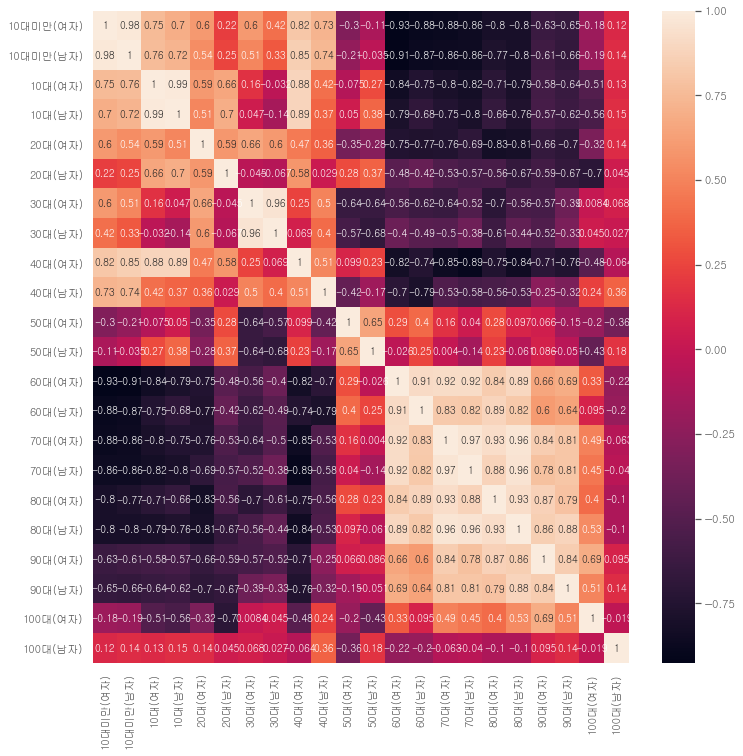

In [56]:
sns.heatmap(age.corr(), annot=True)
plt.show()

In [57]:
# 10대 이하 청소년으로 묶기
age["u10"] = age.loc[:,"10대미만(여자)":"10대(남자)"].sum(axis=1)
list_temp = age.loc[:,"10대미만(여자)":"10대(남자)"].columns
age = age.drop(list_temp,axis=1)

In [58]:
# 30대 청소년으로 묶기
age["p30"] = age.loc[:,"30대(여자)":"30대(남자)"].sum(axis=1)
list_temp = age.loc[:,"30대(여자)":"30대(남자)"].columns
age = age.drop(list_temp,axis=1)

In [59]:
# 60대 이상 중년층으로 묶기
age["o60"] = age.loc[:,"60대(여자)":"100대(남자)"].sum(axis=1)
list_temp = age.loc[:,"60대(여자)":"100대(남자)"].columns
age = age.drop(list_temp,axis=1)

In [60]:
train = pd.merge(train,age,how = 'left', on = '지역')
test = pd.merge(test,age,how = 'left', on = '지역')

In [61]:
train = train.set_index('단지코드')
test = test.set_index('단지코드')

### 3.3 임대료, 임대보증금

In [62]:
imp_tr = pd.read_csv('data/train.imp.csv', encoding = 'ansi')
imp_te = pd.read_csv('data/test.imp.csv', encoding = 'ansi')

In [63]:
train = pd.merge(train,imp_tr.groupby("단지코드").median().loc[:,"임대보증금":"임대료"],how = 'left', on = '단지코드')
test = pd.merge(test,imp_te.groupby("단지코드").median().loc[:,"임대보증금":"임대료"],how = 'left', on = '단지코드')
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, C1072 to C2189
Data columns (total 47 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   총세대수            150 non-null    float64
 1   지역              150 non-null    object 
 2   주거율             150 non-null    float64
 3   지하철역수           150 non-null    float64
 4   버스정류장수          150 non-null    float64
 5   단지내주차면수         150 non-null    float64
 6   총임대가구수          150 non-null    float64
 7   면적_15           150 non-null    float64
 8   면적_20           150 non-null    float64
 9   면적_30           150 non-null    float64
 10  면적_40           150 non-null    float64
 11  면적_50           150 non-null    float64
 12  면적_60           150 non-null    float64
 13  면적_70           150 non-null    float64
 14  면적_80           150 non-null    float64
 15  면적_100          150 non-null    float64
 16  임대비율            150 non-null    float64
 17  가구당주차면수         150 non-null    fl

## 4. 예측

### 4.1 Catboost

In [64]:
#!pip install catboost

In [65]:
from catboost import CatBoostRegressor

In [66]:
cat_features = ['지역']
target_col = '등록차량수'

In [67]:
from catboost import CatBoostRegressor
catb = CatBoostRegressor(
         cat_features=cat_features,
         loss_function='MAE',
         n_estimators=500, 
         learning_rate=0.05, 
         random_state=42
    )
    
catb.fit(train.drop(columns=[target_col]), train[target_col], verbose=100)

0:	learn: 278.9852856	total: 146ms	remaining: 1m 12s
100:	learn: 79.8592465	total: 1.47s	remaining: 5.82s
200:	learn: 54.7105604	total: 2.79s	remaining: 4.15s
300:	learn: 42.1493699	total: 4.13s	remaining: 2.73s
400:	learn: 34.9163478	total: 5.43s	remaining: 1.34s
499:	learn: 29.8704779	total: 6.75s	remaining: 0us


In [68]:
sample_submission = pd.read_csv('data/sample_submission.csv')
sample_submission.head()

,code,num
0,C1072,0
1,C1128,0
2,C1456,0
3,C1840,0
4,C1332,0


In [69]:
sample_submission['num'] = catb.predict(test)

In [70]:
sample_submission

,code,num
0,C1072,755.506593
1,C1128,1177.071660
2,C1456,477.019282
3,C1840,486.829515
4,C1332,1095.936086
...,...,...
145,C2456,221.566785
146,C1266,445.105584
147,C2152,43.790208
148,C1267,426.426734


In [71]:
sample_submission.to_csv('submission_catb_baseline_20210711_15.csv', index=False)

### 4.2 Randomforest

In [72]:
from sklearn.ensemble import RandomForestRegressor

In [73]:
train_RF = train
test_RF = test
train_RF["지역"] = train["지역"].astype('category').cat.codes
test_RF["지역"] = test["지역"].astype('category').cat.codes
# train_RF["임대건물구분"] = train["임대건물구분"].astype('category').cat.codes
# test_RF["임대건물구분"] = test["임대건물구분"].astype('category').cat.codes

In [74]:
x_train = train_RF.drop(columns=["등록차량수"])
y_train = train_RF.loc[:,"등록차량수"]
x_test = test_RF

In [75]:
model = RandomForestRegressor(n_jobs=-1, random_state=42)

In [76]:
model.fit(x_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [77]:
pred = model.predict(x_test)

In [78]:
submission = pd.read_csv('data/sample_submission.csv')

In [79]:
submission['num'] = pred

In [80]:
submission

,code,num
0,C1072,754.11
1,C1128,1225.24
2,C1456,521.55
3,C1840,508.87
4,C1332,1080.28
...,...,...
145,C2456,281.19
146,C1266,459.43
147,C2152,47.13
148,C1267,423.96


In [81]:
submission.to_csv('baseline0711_15.csv', index=False)

### 4.3.2 Randomforest

In [82]:
corr = train_RF.corr()["등록차량수"].abs().sort_values(ascending=False)
corr.head(20)


등록차량수             1.000000
단지내주차면수           0.847196
총세대수              0.596356
총임대가구수            0.586707
가구당주차면수           0.512999
임대료               0.481635
공급유형_공공임대(10년)    0.410467
임대보증금             0.388964
p30               0.335511
공급유형_임대상가         0.317295
자격유형_D            0.317295
자격유형_C            0.305958
주거율               0.291565
면적_70             0.266881
면적_30             0.266387
면적_100            0.262414
50대(남자)           0.252389
자격유형_A            0.239622
면적_20             0.231817
공급유형_공공임대(분납)     0.224761
Name: 등록차량수, dtype: float64

In [83]:
X = train_RF.copy()
X = X.loc[:,corr.index[0:20]]
X.drop(['등록차량수',  ],axis=1, inplace=True)
feature_names = X.columns.to_list()
# scaler = StandardScaler()
# X = scaler.fit(X).transform(X)

y = train_RF.loc[:,'등록차량수']

# 피쳐 선택은 나중에 우선 상관도 높은 20개 사용 

In [84]:
model = RF = RandomForestRegressor(n_jobs=-1, random_state=300, max_depth =12,min_samples_leaf =2,min_samples_split=2,n_estimators=200)
model.fit(X, y)

X_test = test_RF[feature_names]
pred = RF.predict(X_test)

submission['num'] = pred
submission.to_csv('baseline0711_15_RF_cod.csv', index=False)

In [85]:
submission

,code,num
0,C1072,742.189403
1,C1128,1238.518381
2,C1456,561.997126
3,C1840,508.157408
4,C1332,1084.743022
...,...,...
145,C2456,247.873864
146,C1266,501.830780
147,C2152,42.157232
148,C1267,440.201736


In [86]:
train.to_csv("train0715.csv",encoding = 'ansi')
test.to_csv("test0715.csv",encoding = 'ansi')

In [87]:
from tqdm import tqdm
import plotly 
import plotly.express as px
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import matplotlib
from matplotlib import font_manager, rc
import shap

In [88]:


explainer = shap.TreeExplainer(RF) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(X_test) # Shap Values 계산
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], feature_names)

## 빨간색 영향도 높음, 파란색 영향도 낮음(음의 영향력)

In [89]:
shap.force_plot(explainer.expected_value, shap_values, X_test,feature_names) 
#x축. y축 title을 클릭하면 drop down 생성, 전 피처에 대하여 영향력 확인 가능 

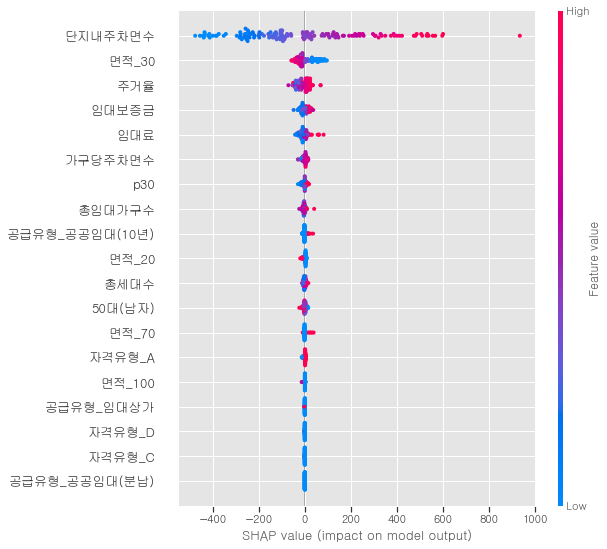

In [90]:
shap.summary_plot(shap_values, X_test,feature_names)

# 모든 변수들의 shap value를 요약한 것으로 해당 변수가 빨간색을 띄면 target(price)에 대해 양의 영향력, 파란색을 띄면 음의 영향력을 가진다.

In [91]:
train_m[train_m["단지코드"]=="C1874"]

,단지코드,총세대수,임대건물구분,지역,공급유형,전용면적,전용면적별세대수,공가수,자격유형,임대보증금,...,60M,70F,70M,80F,80M,90F,90M,100F,100M,총전용면적
90,C1874,619,아파트,충청남도,영구임대,20.0,294,2,C,3141000,...,0.057692,0.042296,0.028682,0.024514,0.0109,0.005429,0.001549,0.000219,0.000123,5880.0
91,C1874,619,아파트,충청남도,영구임대,20.0,149,2,C,3141000,...,0.057692,0.042296,0.028682,0.024514,0.0109,0.005429,0.001549,0.000219,0.000123,2980.0
92,C1874,619,아파트,충청남도,영구임대,30.0,149,2,C,3731000,...,0.057692,0.042296,0.028682,0.024514,0.0109,0.005429,0.001549,0.000219,0.000123,4470.0
93,C1874,619,상가,충청남도,임대상가,15.0,1,2,D,0,...,0.057692,0.042296,0.028682,0.024514,0.0109,0.005429,0.001549,0.000219,0.000123,15.0
94,C1874,619,상가,충청남도,임대상가,15.0,1,2,D,0,...,0.057692,0.042296,0.028682,0.024514,0.0109,0.005429,0.001549,0.000219,0.000123,15.0
95,C1874,619,상가,충청남도,임대상가,15.0,1,2,D,0,...,0.057692,0.042296,0.028682,0.024514,0.0109,0.005429,0.001549,0.000219,0.000123,15.0
96,C1874,619,상가,충청남도,임대상가,20.0,1,2,D,0,...,0.057692,0.042296,0.028682,0.024514,0.0109,0.005429,0.001549,0.000219,0.000123,20.0
97,C1874,619,상가,충청남도,임대상가,20.0,1,2,D,0,...,0.057692,0.042296,0.028682,0.024514,0.0109,0.005429,0.001549,0.000219,0.000123,20.0
98,C1874,619,상가,충청남도,임대상가,20.0,1,2,D,0,...,0.057692,0.042296,0.028682,0.024514,0.0109,0.005429,0.001549,0.000219,0.000123,20.0
99,C1874,619,상가,충청남도,임대상가,20.0,1,2,D,0,...,0.057692,0.042296,0.028682,0.024514,0.0109,0.005429,0.001549,0.000219,0.000123,20.0
